In [1]:
import pandas as pd

In [2]:
# Training dataset processing
train_data = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')

# Missing value handling
# Fill missing values
train_data['health_insurance'] = train_data['health_insurance'].fillna('Unknown')
train_data['employment_industry'] = train_data['employment_industry'].fillna('Unknown')
train_data['employment_occupation'] = train_data['health_insurance'].fillna('Unknown')
train_data['income_poverty'] = train_data['income_poverty'].replace({
    'Below Poverty': 1,
    '<= $75,000, Above Poverty': 2,
    '> $75,000': 3
})
median_income = train_data['income_poverty'].median()
train_data['income_poverty'] = train_data['income_poverty'].fillna(median_income)
train_data['doctor_recc_seasonal'].fillna(train_data['doctor_recc_seasonal'].mode()[0], inplace=True)
train_data['doctor_recc_h1n1'].fillna(train_data['doctor_recc_h1n1'].mode()[0], inplace=True)
freq = train_data['rent_or_own'].value_counts()
most_common = freq.index[0]
train_data['rent_or_own'].fillna(most_common, inplace=True)
freq1 = train_data['employment_status'].value_counts()
most_common1 = freq1.index[0]
train_data['employment_status'].fillna(most_common1, inplace=True)
str_features = ['marital_status', 'education', 'chronic_med_condition', 'child_under_6_months', 'health_worker',
                'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'opinion_seas_vacc_effective',
                'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'household_children',
                'household_adults', 'behavioral_touch_face', 'h1n1_knowledge','employment_industry','employment_occupation']
for feature in str_features:
    mode_val = train_data[feature].mode()[0]
    train_data[feature] = train_data[feature].fillna(mode_val)

# Delete rows with missing values
drop_features = ['h1n1_concern', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds',
                 'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands']
train_data = train_data.dropna(subset=drop_features)

# One-hot
cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
               'rent_or_own', 'census_msa', 'hhs_geo_region','employment_industry','employment_occupation']
onehot_train_data = pd.get_dummies(train_data[cat_columns])
new_train_features = pd.concat([train_data.drop(cat_columns, axis=1), onehot_train_data], axis=1)

new_train_all_data = new_train_features.merge(train_labels, on='respondent_id')
train_features = new_train_all_data.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)
train_labels = new_train_all_data[['h1n1_vaccine', 'seasonal_vaccine']]


In [3]:
# Test dataset processing
test_data =pd.read_csv('test_set_features.csv')

# Missing value handling
# Fill missing values
test_data['health_insurance'] = test_data['health_insurance'].fillna('Unknown')
test_data['employment_industry'] = test_data['employment_industry'].fillna('Unknown')
test_data['employment_occupation'] = test_data['health_insurance'].fillna('Unknown')
test_data['income_poverty'] = test_data['income_poverty'].replace({
    'Below Poverty': 1,
    '<= $75,000, Above Poverty': 2,
    '> $75,000': 3
})
median_income = test_data['income_poverty'].median()
test_data['income_poverty'] = test_data['income_poverty'].fillna(median_income)
test_data['doctor_recc_seasonal'].fillna(test_data['doctor_recc_seasonal'].mode()[0], inplace=True)
test_data['doctor_recc_h1n1'].fillna(test_data['doctor_recc_h1n1'].mode()[0], inplace=True)
freq = test_data['rent_or_own'].value_counts()
most_common = freq.index[0]
test_data['rent_or_own'].fillna(most_common, inplace=True)
freq1 = test_data['employment_status'].value_counts()
most_common1 = freq1.index[0]
test_data['employment_status'].fillna(most_common1, inplace=True)
str_features = ['marital_status', 'education', 'chronic_med_condition', 'child_under_6_months', 'health_worker',
                'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'opinion_seas_vacc_effective',
                'opinion_h1n1_sick_from_vacc', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'household_children',
                'household_adults', 'behavioral_touch_face', 'h1n1_knowledge','employment_industry','employment_occupation',
                'h1n1_concern', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds',
                'behavioral_antiviral_meds', 'behavioral_face_mask', 'behavioral_avoidance', 'behavioral_wash_hands'
                ]
for feature in str_features:
    mode_val = test_data[feature].mode()[0]
    test_data[feature] = test_data[feature].fillna(mode_val)

# One-hot
cat_columns = ['health_insurance', 'age_group', 'education', 'race', 'sex', 'marital_status', 'employment_status',
               'rent_or_own', 'census_msa', 'hhs_geo_region','employment_industry','employment_occupation']
onehot_test_data = pd.get_dummies(test_data[cat_columns])
new_test_data = pd.concat([test_data.drop(cat_columns, axis=1), onehot_test_data], axis=1)


In [4]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on the training data and transform the training data
train_features_scaled = pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)

# Replace the old train_features with the new scaled train_features
train_features = train_features_scaled

In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on the training data and transform the training data
new_test_data_scaled  = pd.DataFrame(scaler.fit_transform(new_test_data), columns=new_test_data.columns)

# Replace the old train_features with the new scaled train_features
new_test_data= new_test_data_scaled

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class PyTorchMLPClassifier:
    def __init__(self, hidden_size=64, output_size=1, batch_size=64, learning_rate=0.0001, num_epochs=120,
                 lr_decay_step_size=1, lr_decay_gamma=0.9, dropout_rate=0.2, random_state=None):
        self.input_size = None
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.dropout_rate = dropout_rate
        self.random_state = random_state

        self.model = None
        self.criterion = nn.BCELoss()
        self.optimizer = None
        self.scheduler = None

        self.train_loss_history = []
        self.valid_loss_history = []
        self.lr_history = []

    class Net(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super().__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, output_size)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.sigmoid(out)
            return out

    def fit(self, X, y, X_valid=None, y_valid=None):
        # Set input_size based on X's number of features
        self.input_size = X.shape[1]

        # Create model, optimizer and scheduler after input_size is determined
        self.model = self.Net(self.input_size, self.hidden_size, self.output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=self.num_epochs, eta_min=self.learning_rate/100)

        X_train_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y_train_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32).unsqueeze(1)  # Add extra dimension
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.num_epochs):
            self.model.train()
            train_loss = 0

            for batch_x, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            # Record learning rate
            self.lr_history.append(self.scheduler.get_last_lr()[0])

            # Record train loss
            self.train_loss_history.append(train_loss / len(train_loader))

            # If validation data is provided, compute and record validation loss
            if X_valid is not None and y_valid is not None:
                self.model.eval()
                with torch.no_grad():
                    X_valid_tensor = torch.tensor(X_valid.to_numpy(), dtype=torch.float32)
                    y_valid_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.float32).unsqueeze(1)
                    outputs = self.model(X_valid_tensor)
                    valid_loss = self.criterion(outputs, y_valid_tensor)
                self.valid_loss_history.append(valid_loss.item())

            self.scheduler.step()


    def predict_proba(self, X):
        X_test_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.model.eval()

        with torch.no_grad():
            outputs = self.model(X_test_tensor)
        proba = outputs.numpy()
        return np.hstack([1 - proba, proba])


    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

    def get_params(self, deep=True):
        # Suppose this estimator has parameters "alpha" and "recursive"
        return {"hidden_size": self.hidden_size, "output_size": self.output_size, "learning_rate": self.learning_rate, "num_epochs": self.num_epochs}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    import matplotlib.pyplot as plt

    def plot_lr_history(clf):
        plt.plot(clf.lr_history)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate History')
        plt.show()

    def plot_loss_history(clf):
        plt.plot(clf.train_loss_history, label='Train')
        if clf.valid_loss_history:
            plt.plot(clf.valid_loss_history, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.legend()
        plt.show()

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Define an ablation experiment
def ablation_experiment_v2(feature_groups, train_features, train_labels, model,k):
    best_auc_h1n1 = 0
    best_auc_seasonal = 0
    best_h1n1_model = None
    best_seasonal_model = None

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (group_name, feature_group) in enumerate(feature_groups.items()):
        print(f'Performing ablation experiment by excluding {group_name}...')

        # Remove the feature group from training data
        features_to_remove = feature_group
        features_filtered = train_features.drop(features_to_remove, axis=1)

        # Initialize cross-validation
        skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

        for target_label, color in zip(['h1n1_vaccine', 'seasonal_vaccine'], ['b', 'r']):
            print(f'Training and evaluating model for {target_label}...')
            aucs = []

            for train_index, val_index in skf.split(features_filtered, train_labels[target_label]):
                X_train, X_val = features_filtered.iloc[train_index], features_filtered.iloc[val_index]
                y_train, y_val = train_labels[target_label].iloc[train_index], train_labels[target_label].iloc[val_index]

                # Train the model
                model.fit(X_train, y_train)

                # Predict probabilities
                probabilities = model.predict_proba(X_val)

                # Compute ROC curve and ROC area
                fpr, tpr, _ = roc_curve(y_val, probabilities[:, 1])
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)

            mean_auc = np.mean(aucs)
            print(f'Average ROC AUC score for {target_label}: {mean_auc:.3f}')

            # Update the best model if current model is better
            if target_label == 'h1n1_vaccine' and mean_auc > best_auc_h1n1:
                best_auc_h1n1 = mean_auc
                best_h1n1_model = model
            elif target_label == 'seasonal_vaccine' and mean_auc > best_auc_seasonal:
                best_auc_seasonal = mean_auc
                best_seasonal_model = model

            # Set the current subplot to be the active one
            plt.sca(axes[i])

            # Plot ROC curve
            plt.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve for {target_label} (area = {roc_auc:.3f})')

        # Plot settings
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve\nExcluding {group_name}')
        plt.legend(loc="lower right")

    # Show the plot
    plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure.
    plt.show()

    return best_h1n1_model, best_seasonal_model

In [8]:
# Respondents' personal backgrounds
personal_backgrounds = [
    'respondent_id',
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    'employment_industry',
    'employment_occupation',
    'health_worker',
    'health_insurance',
    'chronic_med_condition',
    'child_under_6_months'
]

# Respondents' perceptions of vaccines
perceptions_of_vaccines = [
    'h1n1_concern',
    'h1n1_knowledge',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc'
]

# Respondents' daily behaviors
daily_behaviors = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face'
]

Performing ablation experiment by excluding Respondents' personal backgrounds...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.825
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.827
Performing ablation experiment by excluding Respondents' perceptions of vaccines...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.743
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.737
Performing ablation experiment by excluding Respondents' daily behaviors...
Training and evaluating model for h1n1_vaccine...
Average ROC AUC score for h1n1_vaccine: 0.864
Training and evaluating model for seasonal_vaccine...
Average ROC AUC score for seasonal_vaccine: 0.858


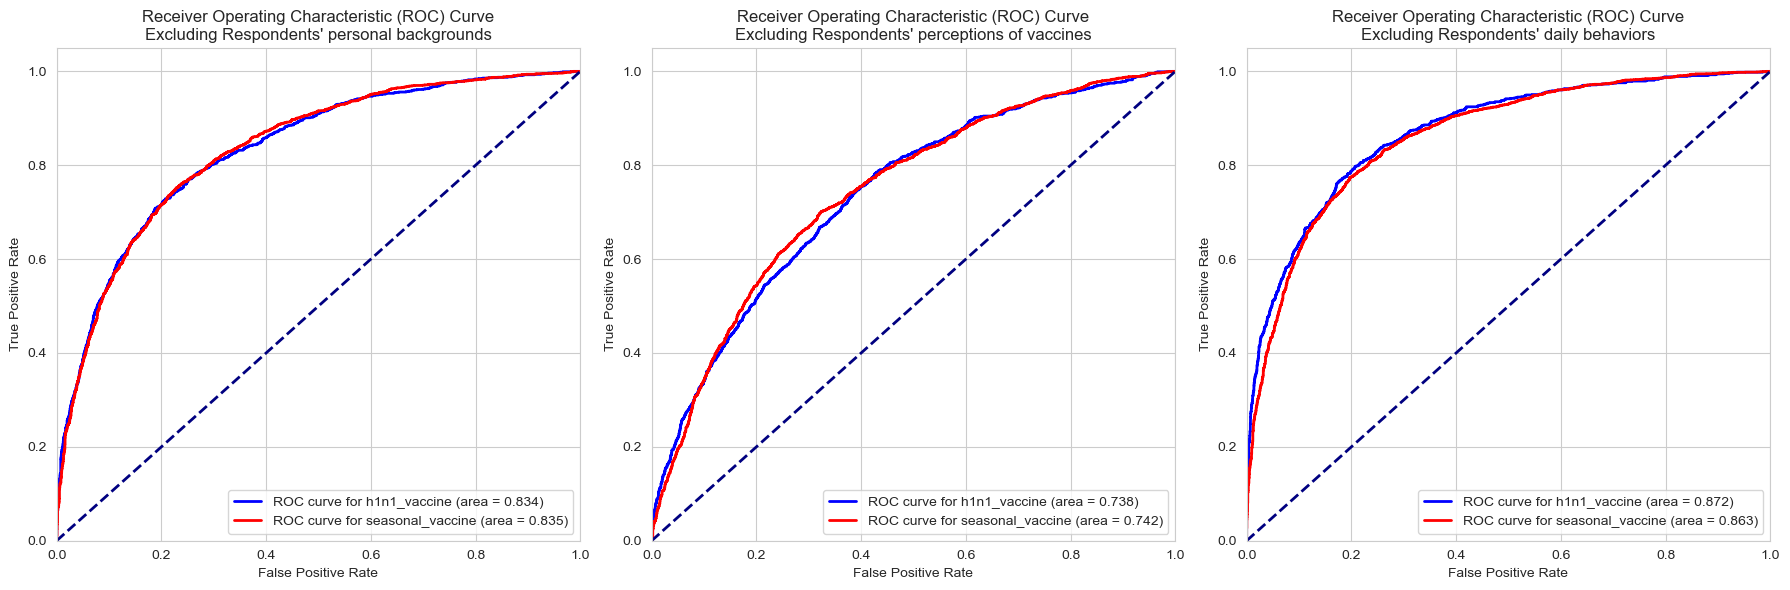

In [9]:
# One-hot encoded columns
onehot_columns = onehot_train_data.columns.tolist()

# Replace the one-hot encoded features in the original feature list with the encoded columns
personal_backgrounds = [col for col in personal_backgrounds if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(personal_backgrounds))]
perceptions_of_vaccines = [col for col in perceptions_of_vaccines if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(perceptions_of_vaccines))]
daily_behaviors = [col for col in daily_behaviors if col not in cat_columns] + [col for col in onehot_columns if col.startswith(tuple(daily_behaviors))]

feature_groups = {
    "Respondents' personal backgrounds": personal_backgrounds,
    "Respondents' perceptions of vaccines": perceptions_of_vaccines,
    "Respondents' daily behaviors": daily_behaviors
}
# Invoke the ablation experiment method
model1 = PyTorchMLPClassifier()
best_h1n1_model, best_seasonal_model = ablation_experiment_v2(feature_groups, train_features, train_labels, model1, 5)

In [14]:
train_labels = pd.read_csv('test_set_features.csv')
X_test_AE = new_test_data.drop(daily_behaviors, axis =1)
y_h1n1_predict_AE = best_h1n1_model.predict_proba(X_test_AE)[:,1]
y_seasonal_predict_AE = best_seasonal_model.predict_proba(X_test_AE)[:,1]
results = pd.DataFrame({'respondent_id': train_labels['respondent_id'], 'h1n1_vaccine': y_h1n1_predict_AE , 'seasonal_vaccine': y_seasonal_predict_AE})
# Output the result as csv file
results.to_csv('result/predictions_ablation_experiment_test.csv', index=False)